In [5]:
import pandas as pd

# Load the CSV file
file_path = "mental_health_support.csv"
data = pd.read_csv(file_path)

# Display the summary of the data
print("Summary of the dataset:")
print(data.describe(include='all'))  # Includes numeric and non-numeric columns


Summary of the dataset:
         subreddit     author        date  \
count       458144     458144      458144   
unique          15     314304         587   
top     depression  [deleted]  2020/01/01   
freq        117331         29        2056   

                                                     post  
count                                              458144  
unique                                             394431  
top     has anyone taken olanzapine/zyprexa or valproa...  
freq                                                   12  


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import os

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "mental_health_support.csv"
data = pd.read_csv(file_path)

# Get unique subreddits
subreddits = data['subreddit'].unique()



[nltk_data] Downloading package punkt to /home/gulizhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gulizhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gulizhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
subreddits

array(['EDAnonymous', 'addiction', 'alcoholism', 'adhd', 'socialanxiety',
       'anxiety', 'healthanxiety', 'autism', 'bipolarreddit', 'bpd',
       'depression', 'lonely', 'ptsd', 'schizophrenia', 'suicidewatch'],
      dtype=object)

In [8]:
# Preprocessing function for text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())  # Tokenization
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Function to extract keywords from clusters
def extract_keywords(tfidf_matrix, feature_names, cluster_labels, top_n=10):
    clusters = {}
    for cluster in set(cluster_labels):
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0).tolist()[0]
        top_features = sorted(list(zip(feature_names, cluster_tfidf)), key=lambda x: x[1], reverse=True)
        clusters[cluster] = [word for word, score in top_features[:top_n]]
    return clusters

# Directory to save results
output_dir = "clustering_results"
os.makedirs(output_dir, exist_ok=True)

# Process each subreddit
for subreddit in subreddits:
    print(f"Processing subreddit: {subreddit}")
    subreddit_data = data[data['subreddit'] == subreddit]

    # Convert 'date' to datetime and sort
    subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')
    subreddit_data = subreddit_data.dropna(subset=['date']).sort_values('date')

    # Group data by half-year
    subreddit_data['half_year'] = subreddit_data['date'].apply(lambda x: f"{x.year}-{(x.month-1)//6 + 1}")
    grouped_data = subreddit_data.groupby('half_year')

    # Process each half-year
    for half_year, posts in grouped_data:
        print(f"  Processing half-year: {half_year}")
        
        # Preprocess the text
        posts_text = posts['post'].dropna().apply(preprocess_text).tolist()
        
        # TF-IDF feature extraction for unigrams
        tfidf_vectorizer_unigrams = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
        tfidf_matrix_unigrams = tfidf_vectorizer_unigrams.fit_transform(posts_text)
        feature_names_unigrams = tfidf_vectorizer_unigrams.get_feature_names()  # Compatible with older versions

        # TF-IDF feature extraction for bigrams
        tfidf_vectorizer_bigrams = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
        tfidf_matrix_bigrams = tfidf_vectorizer_bigrams.fit_transform(posts_text)
        feature_names_bigrams = tfidf_vectorizer_bigrams.get_feature_names()  # Compatible with older versions

        # K-Means clustering
        num_clusters = 5  # Number of clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix_unigrams)
        
        # Extract keywords for unigrams
        keywords_unigrams = extract_keywords(tfidf_matrix_unigrams, feature_names_unigrams, cluster_labels, top_n=10)
        
        # Extract keywords for bigrams
        keywords_bigrams = extract_keywords(tfidf_matrix_bigrams, feature_names_bigrams, cluster_labels, top_n=10)
        
        # Save results for this half-year
        results = []
        for cluster in keywords_unigrams.keys():
            results.append({
                "subreddit": subreddit,
                "half_year": half_year,
                "cluster": cluster,
                "top_10_unigrams": ', '.join(keywords_unigrams[cluster]),
                "top_10_bigrams": ', '.join(keywords_bigrams[cluster])
            })
        
        # Save results to CSV
        output_file = os.path.join(output_dir, f"{subreddit}_{half_year}_clusters.csv")
        pd.DataFrame(results).to_csv(output_file, index=False)
        print(f"  Saved results to {output_file}")


Processing subreddit: EDAnonymous
  Processing half-year: 2018-2


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/EDAnonymous_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/EDAnonymous_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/EDAnonymous_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/EDAnonymous_2020-1_clusters.csv
Processing subreddit: addiction
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/addiction_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/addiction_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/addiction_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/addiction_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/addiction_2020-1_clusters.csv
Processing subreddit: alcoholism
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/alcoholism_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/alcoholism_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/alcoholism_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/alcoholism_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/alcoholism_2020-1_clusters.csv
Processing subreddit: adhd


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Processing half-year: 2018-1
  Saved results to clustering_results/adhd_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/adhd_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/adhd_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/adhd_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/adhd_2020-1_clusters.csv
Processing subreddit: socialanxiety


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Processing half-year: 2018-1
  Saved results to clustering_results/socialanxiety_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/socialanxiety_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/socialanxiety_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/socialanxiety_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/socialanxiety_2020-1_clusters.csv
Processing subreddit: anxiety


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Processing half-year: 2018-1
  Saved results to clustering_results/anxiety_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/anxiety_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/anxiety_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/anxiety_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/anxiety_2020-1_clusters.csv
Processing subreddit: healthanxiety
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/healthanxiety_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/healthanxiety_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/healthanxiety_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/healthanxiety_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/healthanxiety_2020-1_clusters.csv
Processing subreddit: autism
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/autism_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/autism_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/autism_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/autism_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/autism_2020-1_clusters.csv
Processing subreddit: bipolarreddit
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/bipolarreddit_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/bipolarreddit_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/bipolarreddit_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/bipolarreddit_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/bipolarreddit_2020-1_clusters.csv
Processing subreddit: bpd
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/bpd_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/bpd_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/bpd_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/bpd_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/bpd_2020-1_clusters.csv
Processing subreddit: depression


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Processing half-year: 2018-1
  Saved results to clustering_results/depression_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/depression_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/depression_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/depression_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/depression_2020-1_clusters.csv
Processing subreddit: lonely
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/lonely_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/lonely_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/lonely_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/lonely_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/lonely_2020-1_clusters.csv
Processing subreddit: ptsd
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/ptsd_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/ptsd_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/ptsd_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/ptsd_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/ptsd_2020-1_clusters.csv
Processing subreddit: schizophrenia
  Processing half-year: 2018-1


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Saved results to clustering_results/schizophrenia_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/schizophrenia_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/schizophrenia_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/schizophrenia_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/schizophrenia_2020-1_clusters.csv
Processing subreddit: suicidewatch


/tmp/ipykernel_1375796/2662250088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subreddit_data['date'] = pd.to_datetime(subreddit_data['date'], errors='coerce')


  Processing half-year: 2018-1
  Saved results to clustering_results/suicidewatch_2018-1_clusters.csv
  Processing half-year: 2018-2
  Saved results to clustering_results/suicidewatch_2018-2_clusters.csv
  Processing half-year: 2019-1
  Saved results to clustering_results/suicidewatch_2019-1_clusters.csv
  Processing half-year: 2019-2
  Saved results to clustering_results/suicidewatch_2019-2_clusters.csv
  Processing half-year: 2020-1
  Saved results to clustering_results/suicidewatch_2020-1_clusters.csv


In [1]:
import os
import pandas as pd


output_dir = "clustering_results" 
merged_file_path = "merged_clusters_output.csv"  


merged_data = pd.DataFrame()


for file_name in os.listdir(output_dir):
    if file_name.endswith(".csv"):  
        file_path = os.path.join(output_dir, file_name)
        print(f"Reading file: {file_path}")
        current_data = pd.read_csv(file_path)
        merged_data = pd.concat([merged_data, current_data], ignore_index=True)

merged_data.to_csv(merged_file_path, index=False)
print(f"All files merged into: {merged_file_path}")


Reading file: clustering_results/lonely_2020-1_clusters.csv
Reading file: clustering_results/socialanxiety_2018-1_clusters.csv
Reading file: clustering_results/healthanxiety_2019-2_clusters.csv
Reading file: clustering_results/suicidewatch_2020-1_clusters.csv
Reading file: clustering_results/bipolarreddit_2019-1_clusters.csv
Reading file: clustering_results/addiction_2018-1_clusters.csv
Reading file: clustering_results/ptsd_2019-2_clusters.csv
Reading file: clustering_results/anxiety_2020-1_clusters.csv
Reading file: clustering_results/lonely_2019-1_clusters.csv
Reading file: clustering_results/healthanxiety_2019-1_clusters.csv
Reading file: clustering_results/ptsd_2019-1_clusters.csv
Reading file: clustering_results/adhd_2018-1_clusters.csv
Reading file: clustering_results/depression_2020-1_clusters.csv
Reading file: clustering_results/suicidewatch_2019-1_clusters.csv
Reading file: clustering_results/healthanxiety_2018-2_clusters.csv
Reading file: clustering_results/anxiety_2019-2_clu

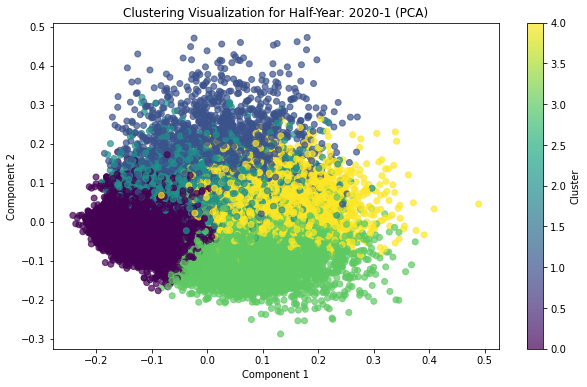

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to plot clusters
def plot_clusters(tfidf_matrix, cluster_labels, half_year, method="PCA"):
    # Reduce dimensionality
    if method == "PCA":
        reducer = PCA(n_components=2, random_state=42)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'PCA' or 'TSNE'.")
    
    reduced_data = reducer.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to dense
    x = reduced_data[:, 0]
    y = reduced_data[:, 1]

    # Plot clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f"Clustering Visualization for Half-Year: {half_year} ({method})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Select one specific half-year to plot
selected_half_year = "2020-1"  # Change this to the desired half-year
selected_posts = grouped_data.get_group(selected_half_year)

# Preprocess the text for the selected half-year
selected_posts_text = selected_posts['post'].dropna().apply(preprocess_text).tolist()

# TF-IDF feature extraction for unigrams
tfidf_vectorizer_unigrams = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
tfidf_matrix_unigrams = tfidf_vectorizer_unigrams.fit_transform(selected_posts_text)

# K-Means clustering for the selected half-year
num_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix_unigrams)

# Plot the clustering result
plot_clusters(tfidf_matrix_unigrams, cluster_labels, selected_half_year, method="PCA")
